<a href="https://colab.research.google.com/github/MatheusMataBIO/Projetos-de-ciencias-de-dados-/blob/main/recomenda%C3%A7ao_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Permite que seja acessado arquivos e diretórios do Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cria um arquivo kaggle.json com suas credenciais, permitindo que você use a API do Kaggle em seu notebook

%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Writing kaggle.json


In [4]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

  Using cached kaggle-1.6.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# Fazendo o download do dataset do Kaggle e descompactando o arquivo

!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [6]:
# Função que removerá um número de quantidade de imagens definidas

import os

def remover_imagens(pasta, num_imagens):
    # Lista todos os arquivos na pasta
    arquivos = os.listdir(pasta)

    # Contador de imagens removidas
    imagens_removidas = 0

    # Percorre os arquivos na pasta
    for arquivo in arquivos:
        # Verifica se o arquivo é uma imagem
        if arquivo.endswith(".jpg") or arquivo.endswith(".png") or arquivo.endswith(".jpeg"):
            # Remove o arquivo
            os.remove(os.path.join(pasta, arquivo))
            imagens_removidas += 1

            # Verifica se atingiu o número desejado de imagens removidas
            if imagens_removidas == num_imagens:
                break

# Substitua "pasta_com_imagens" pelo caminho da sua pasta no Google Colab
pasta_com_imagens = "/content/images"

# Define o número de imagens a serem removidas
num_imagens_a_remover = 42000

# Chama a função para remover as imagens
remover_imagens(pasta_com_imagens, num_imagens_a_remover)

In [7]:
# Esse bloco organiza os dados das imagens  no diretório criado

import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 2441/2441 [00:09<00:00, 267.69it/s]

Moved 2441 images.


In [8]:
# Verifica as versões do Tensorflow e se há uma GPU instalada

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [11]:
# Configuração para utilizar um modelo de rede neural pré-treinado chamado "m-r50x3" do TensorFlow Hub, especificamente o modelo Bit

MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [12]:
# Esse código cria uma variável chamada "data_dir" que armazena o caminho para um diretório no sistema de arquivos. No caso específico do código fornecido,
# O caminho é '/content/Fashion_data/categories'.

data_dir = '/content/Fashion_data/categories'

In [13]:
# Pré-processamento e geração de dados de imagem para treinamento e validação de modelos de aprendizado profundo usando a biblioteca TensorFlow

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 486 images belonging to 5 classes.
Found 1955 images belonging to 5 classes.


In [14]:
# Construindo um modelo de rede neural para classificação de imagens utilizando TensorFlow e a biblioteca TensorFlow Hub

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 212748485 (811.57 MB)
Trainable params: 1574405 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_____________

In [16]:
# Define o otimizador e a perda

lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Diminui a taxa de aprendizagem por um fator de 10 em SCHEDULE_BOUNDARIES

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [17]:
# Treinando um modelo de rede neural utilizando o Keras, uma biblioteca de Deep Learning em Python

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
61/61 [==============================] - 54s 568ms/step - loss: 0.8435 - accuracy: 0.8757 - val_loss: 0.0967 - val_accuracy: 0.9875
Epoch 2/5
61/61 [==============================] - 33s 540ms/step - loss: 0.2084 - accuracy: 0.9750 - val_loss: 0.1003 - val_accuracy: 0.9896
Epoch 3/5
61/61 [==============================] - 33s 550ms/step - loss: 0.1589 - accuracy: 0.9802 - val_loss: 0.0912 - val_accuracy: 0.9875
Epoch 4/5
61/61 [==============================] - 33s 551ms/step - loss: 0.1792 - accuracy: 0.9771 - val_loss: 0.0869 - val_accuracy: 0.9896
Epoch 5/5
61/61 [==============================] - 33s 550ms/step - loss: 0.1507 - accuracy: 0.9860 - val_loss: 0.0848 - val_accuracy: 0.9896


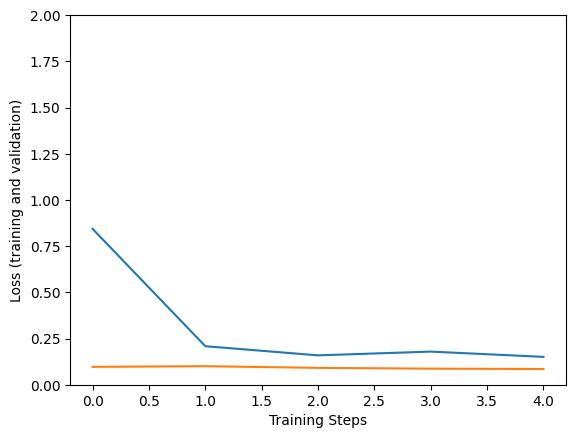

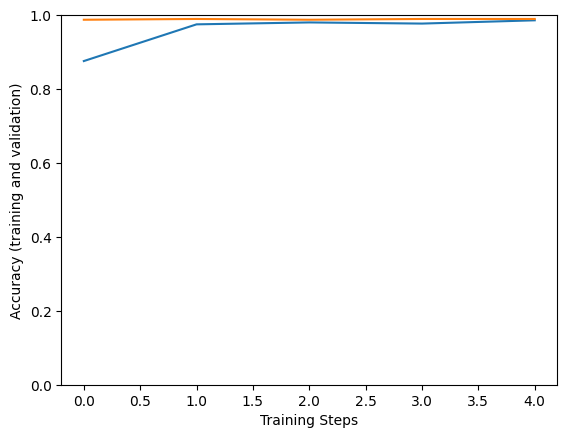

In [18]:
# Utilizando a biblioteca Matplotlib em Python para plotar gráficos que mostram a perda (loss) e a acurácia (accuracy) de um modelo de machine learning durante o treinamento e validação

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [19]:
# Realiza algumas operações relacionadas ao salvamento de um modelo de aprendizado de máquina utilizando a biblioteca TensorFlow

if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

In [20]:

import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [21]:
# Este código cria uma lista chamada 'img_paths que' que armazenará caminhos de arquivos de imagem
# Ele percorre recursivamente todos os arquivos com extensão ".jpg" no diretório '/content/Fashion_data/categories' e em todos os seus subdiretórios
# Para isso, utiliza a biblioteca 'Path' do Python, que facilita a manipulação de caminhos de arquivos e diretórios

img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [22]:
# Essa função carrega uma imagem de um arquivo especificado pelo caminho (path) fornecido

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [23]:
# Este código seleciona um modelo pré-treinado para usar com base no valor da flag 'TRANSFER_LEARNING_FLAG'
# Se a flag for verdadeira, ele carrega um modelo salvo localmente usando TensorFlow Keras; caso contrário, carrega um modelo pré-treinado usando TensorFlow Hub

TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [24]:
# Esse código em Python está lidando com a criação de um diretório para armazenar arquivos de vetores de imagem

imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [25]:
# Este código carrega imagens, extrai características usando um modelo de Machine Learning
# Salva essas características em arquivos separados, usando o nome das imagens como referência

for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 2441/2441 [02:23<00:00, 16.99it/s]


In [26]:

import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


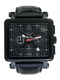

In [28]:
# Utiliza uma imagem do caminho para uma visualização teste
# Obs: Como removemos imagens talvez se o código for rodado mais de uma vez tenha que trocar o número da imagem '10195'
# Para resolver é seguindo o caminho e em accessories buscar um número que esteja na pasta.

test_img = '/content/Fashion_data/categories/Accessories/10194.jpg'
dispImage(test_img)

In [29]:
# Este código lê um arquivo CSV, converte o tipo de dados de uma coluna específica, e então salva o DataFrame resultante em um novo arquivo CSV no mesmo diretório do script

styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
import os
root_path = os.getcwd()
styles.to_csv(root_path+'/styles.csv', index=False)

In [30]:
# Esta função busca o índice onde o atributo 'id' de 'styles' é igual a 'fname' e retorna esse índice
# No entanto, pode gerar um erro se nenhum valor corresponder ao critério de filtragem ou se 'style's não for uma estrutura de dados indexada

def match_id(fname):
  return styles.index[styles.id==fname].values[0]


In [31]:
# Definindo as estruturas de dados como um dicinário vazio
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configurando parâmetros annoy
dims = 256
n_nearest_neighbors = 20
trees = 10000

#Lê todos os nomes de arquivos que armazenam vetores de recursos

allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [32]:
# Esse código carrega arquivos, extrai informações relevantes, como nomes e vetores, e as associa a índices para possibilitar operações eficientes posteriormente
# Também tenta encontrar IDs de produtos correspondentes aos nomes dos arquivos e adiciona os vetores de arquivo a uma estrutura de dados para operações futuras

for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

2441it [00:09, 262.62it/s]


In [33]:

t.build(trees)
t.save('t.ann')

True

In [34]:

file_path = '/content/drive/MyDrive/ImgSim/'

In [35]:
# O código está salvando alguns objetos relacionados à indexação (como modelos, dicionários, etc.) em arquivos para que possam ser facilmente recuperados e reutilizados posteriormente
# O uso do 'pickle' é comum para serializar objetos em Python

t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

In [36]:

from PIL import Image
import matplotlib.image as mpimg

<ipython-input-37-c357d0c2a054>:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((basewidth,hsize), Image.ANTIALIAS)


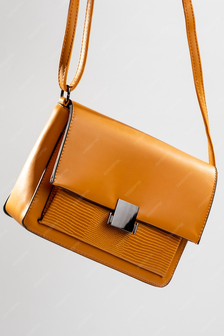

In [37]:
# Definindo uma imagem retirada da internet para ser o modelo para recomendação

img_addr = 'https://img.freepik.com/fotos-gratis/expositor-de-bolsa-feminina-levitando_23-2149817599.jpg?w=740&t=st=1712884055~exp=1712884655~hmac=71638f8677a5903327c91fb9352a6f2094b72372bcea51041a9e68c991a0cc10'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

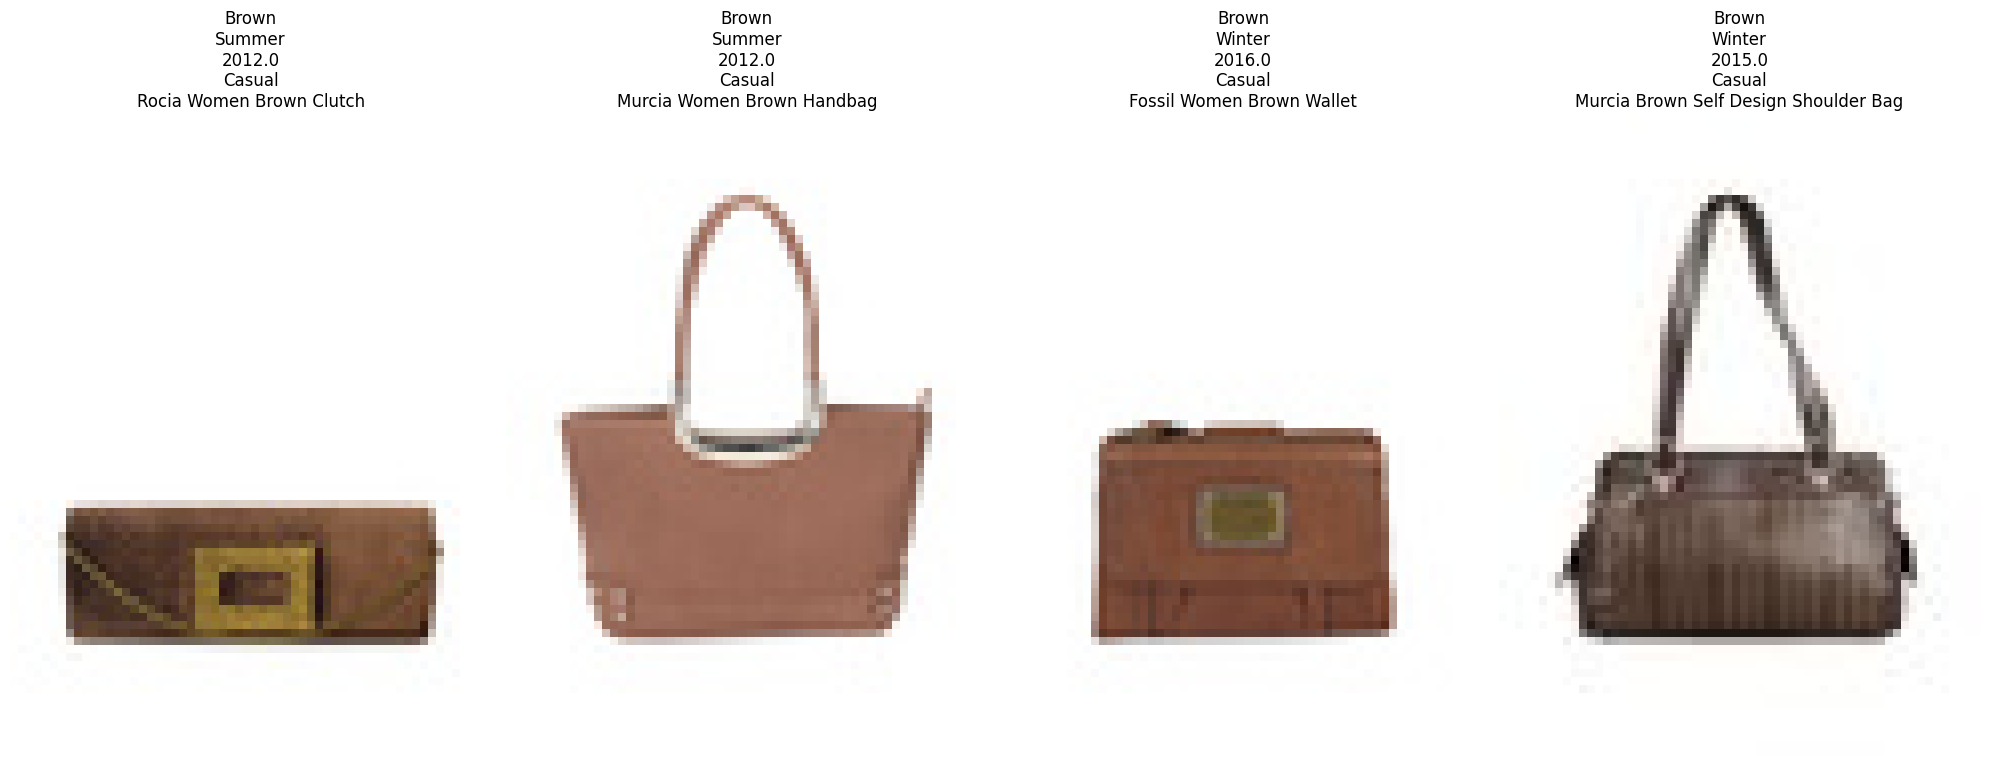

In [38]:
# O código cria um dicionário 'path_dict' que mapeia o nome dos arquivos JPEG encontrados em um diretório específico para seus caminhos completos
# Realiza uma busca por vetores semelhantes usando um índice 't' e retorna os índices dos vetores mais similares em relação ao vetor de teste 'test_vec'
# Usa os índices retornados para exibir as imagens correspondentes junto com algumas informações adicionais

path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()